# 一、定义NP归一化和标准化、转为TENSOR、制作数据集

In [1]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from torch.utils.data import DataLoader

In [2]:
def normalization(data):
    _range = np.max(data)-np.min(data)
    data = (data-np.min(data))/_range
    return data

def standardization(data):
    mu = np.mean(data)
    sigma = np.std(data)
    epsilon = 1e-5
    return (data-mu)/(sigma+epsilon)


In [3]:
import os
classes = ['HRP','HC']

class StructuralDataset(Dataset):
    def __init__(self,data_root):
        self.samples = []

        for label in os.listdir(data_root):
            for no in os.listdir(os.path.join(data_root,label)):
                if label=='HRP':
                    labels = 0
                else:
                    labels = 1
                img = nib.load(os.path.join(data_root,label,no))
                imgdata = img.get_fdata()
                imgdata = np.array(imgdata)
                imgdata = standardization(imgdata)
                imgdata = normalization(imgdata)
                
                imgdata = torch.from_numpy(imgdata)
                imgdata = imgdata.permute(2,0,1)
                ''' add channel '''
                imgdata_c = torch.empty((1,136,256,256))
                imgdata_c[0] = imgdata
                
                self.samples.append((imgdata_c,labels))
    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return self.samples[idx]
    
    
dataset = StructuralDataset('D:\\strucdata')
print(len(dataset))
print(dataset[0][0].shape)

28
torch.Size([1, 136, 256, 256])


In [4]:
dataloader = DataLoader(dataset,batch_size=3, shuffle = True, num_workers=0)

# N x C x D x H x W
for i,batch in enumerate(dataloader):
    print('{0}: {1}, cate:{2}'.format(i,batch[0].shape,batch[1]))

0: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 1])
1: torch.Size([3, 1, 136, 256, 256]), cate:tensor([0, 0, 1])
2: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 1])
3: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 1, 0])
4: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 0])
5: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 1])
6: torch.Size([3, 1, 136, 256, 256]), cate:tensor([0, 1, 0])
7: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 0])
8: torch.Size([3, 1, 136, 256, 256]), cate:tensor([1, 0, 1])
9: torch.Size([1, 1, 136, 256, 256]), cate:tensor([0])


# 二、数据集可视化




torch.Size([3, 1, 136, 256, 256])
torch.Size([3, 1, 256, 256])


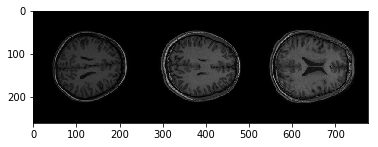

In [5]:
import torchvision

data_test = next(iter(dataloader))
print(data_test[0].shape)
data_test_axial = data_test[0][:,:,78,:,:]
print(data_test_axial.shape)

plt.imshow(torchvision.utils.make_grid(data_test_axial).permute(1,2,0),cmap='Greys')


In [6]:
np.set_printoptions(threshold=np.inf)  
print(np.array(dataset[0][0][0,78,:,:]))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

# 三、定义网络、训练


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class struc_autoencoder(nn.Module):
    
    def __init__(self):
        super(struc_autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(1,3,3,1,1),
            nn.ReLU(),
            #nn.MaxPool3d(kernel_size=2,stride=2,return_indices=True),
            nn.Conv3d(3,6,3,1,1),
            nn.ReLU(),
            #nn.MaxPool3d(kernel_size=2,stride=2,return_indices=True)
        )
        
        self.decoder = nn.Sequential(
            #nn.MaxUnpool3d(2,2),
            nn.ConvTranspose3d(6,3,3,1,1),
            nn.ReLU(),
            #nn.MaxUnpool3d(2,2),
            nn.ConvTranspose3d(3,1,3,1,1),
            nn.ReLU()
        )
        
        self.conv3d_13 = nn.Conv3d(1,3,3,1,1)
        self.conv3d_36 = nn.Conv3d(3,6,3,1,1)
        self.relu = nn.ReLU()
        self.maxp3d = nn.MaxPool3d(kernel_size=2,stride=2,return_indices=True)
        self.unmaxp3d = nn.MaxUnpool3d(2,2)
        self.upconv3d_63 = nn.ConvTranspose3d(6,3,3,1,1)
        self.upconv3d_31 = nn.ConvTranspose3d(3,1,3,1,1)
        
        self.dropout = nn.Dropout(p=0.6)
        self.bn_3c = nn.BatchNorm3d(3)
        self.bn_6c = nn.BatchNorm3d(6)

        #self.unpool2 = nn.MaxUnpool3d(2,2)
        
    def forward(self,x):
        # encoder:
        x, ind1 = self.maxp3d(self.conv3d_13(x))
        x = self.relu(x)
        x, ind2 = self.maxp3d(self.conv3d_36(x))
        x1 = self.relu(x)
        # decoder:
        x = self.upconv3d_63(self.unmaxp3d(x1,ind2))
        x = self.relu(x)
        x = self.upconv3d_31(self.unmaxp3d(x,ind1))
        x = self.relu(x)
        return (x1,x)
    
    

In [8]:
import torch.optim as optim
net = struc_autoencoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

for epoch in range(1):
    
    running_loss = 0.00
    for i,data in enumerate(dataloader,0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        
        outputs = net(inputs)
        loss = criterion(outputs[1], inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('{0} loss:{1}'.format(i, running_loss))
        running_loss = 0


0 loss:0.01159595139324665
1 loss:0.010873395018279552
2 loss:0.01280197873711586
3 loss:0.013141816481947899
4 loss:0.00919739156961441
5 loss:0.009285390377044678
6 loss:0.007644403260201216
7 loss:0.007921701297163963
8 loss:0.0074606165289878845
9 loss:0.011905082501471043


In [14]:
datatest_1, label_test1 = next(iter(dataloader))
output_1 = net(datatest_1)
print(output_1[0].shape)
output_axial = output_1[0][:,:,17,:,:]
print(output_axial.shape)
fig,axes = plt.subplots(3,6)

axes[0][0].imshow(output_axial[0,0,:,:])
'''
axes[0][1].imshow(output_axial[0,1,:,:])
axes[0][2].imshow(output_axial[0,2,:,:])
axes[0][3].imshow(output_axial[0,3,:,:])
axes[0][4].imshow(output_axial[0,4,:,:])
axes[0][5].imshow(output_axial[0,5,:,:])
axes[1][0].imshow(output_axial[1,0,:,:])
axes[1][1].imshow(output_axial[1,1,:,:])
axes[1][2].imshow(output_axial[1,2,:,:])
axes[1][3].imshow(output_axial[1,3,:,:])
axes[1][4].imshow(output_axial[1,4,:,:])
axes[1][5].imshow(output_axial[1,5,:,:])
axes[2][0].imshow(output_axial[2,0,:,:])
axes[2][1].imshow(output_axial[2,1,:,:])
axes[2][2].imshow(output_axial[2,2,:,:])
axes[2][3].imshow(output_axial[2,3,:,:])
axes[2][4].imshow(output_axial[2,4,:,:])
axes[2][5].imshow(output_axial[2,5,:,:])
'''

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1082916864 bytes. Buy new RAM!
